In [1]:
import os
import tensorflow as tf
import tensorflow_datasets as tfds

tf.config.list_physical_devices('GPU') 
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)
        
DATAPATH = os.path.abspath('../../data/')

1 Physical GPUs, 1 Logical GPUs


In [2]:
import numpy as np

imdb, info = tfds.load("imdb_reviews", with_info=True, as_supervised=True)

train_data, test_data = imdb['train'], imdb['test']

training_sentences = []
training_labels = []

testing_sentences = []
testing_labels = []

# str(s.tonumpy()) is needed in Python3 instead of just s.numpy()
for s,l in train_data:
  training_sentences.append(str(s.numpy()))
  training_labels.append(l.numpy())
  
for s,l in test_data:
  testing_sentences.append(str(s.numpy()))
  testing_labels.append(l.numpy())
  
training_labels_final = np.array(training_labels)
testing_labels_final = np.array(testing_labels)


In [3]:
vocab_size = 10000
embedding_dim = 16
max_length = 120
trunc_type='post'
oov_tok = "<OOV>"


from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(training_sentences)
word_index = tokenizer.word_index
sequences = tokenizer.texts_to_sequences(training_sentences)
padded = pad_sequences(sequences,maxlen=max_length, truncating=trunc_type)

testing_sequences = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = pad_sequences(testing_sequences,maxlen=max_length)


In [4]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Bidirectional(tf.keras.layers.GRU(32)),
    tf.keras.layers.Dense(6, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 120, 16)           160000    
_________________________________________________________________
bidirectional (Bidirectional (None, 64)                9600      
_________________________________________________________________
dense (Dense)                (None, 6)                 390       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 7         
Total params: 169,997
Trainable params: 169,997
Non-trainable params: 0
_________________________________________________________________


In [5]:
num_epochs = 50
history = model.fit(padded, training_labels_final, epochs=num_epochs, validation_data=(testing_padded, testing_labels_final))

Epoch 1/50
782/782 [==============================] - 20s 21ms/step - loss: 0.6441 - accuracy: 0.5900 - val_loss: 0.3873 - val_accuracy: 0.8270
Epoch 2/50
782/782 [==============================] - 16s 21ms/step - loss: 0.3144 - accuracy: 0.8704 - val_loss: 0.3597 - val_accuracy: 0.8443
Epoch 3/50
782/782 [==============================] - 16s 20ms/step - loss: 0.2221 - accuracy: 0.9181 - val_loss: 0.3750 - val_accuracy: 0.8355
Epoch 4/50
782/782 [==============================] - 17s 22ms/step - loss: 0.1761 - accuracy: 0.9383 - val_loss: 0.4399 - val_accuracy: 0.8277
Epoch 5/50
782/782 [==============================] - 17s 21ms/step - loss: 0.1237 - accuracy: 0.9581 - val_loss: 0.4943 - val_accuracy: 0.8182
Epoch 6/50
782/782 [==============================] - 18s 22ms/step - loss: 0.1034 - accuracy: 0.9665 - val_loss: 0.5145 - val_accuracy: 0.8193
Epoch 7/50
782/782 [==============================] - 17s 22ms/step - loss: 0.0708 - accuracy: 0.9785 - val_loss: 0.6467 - val_accuracy:

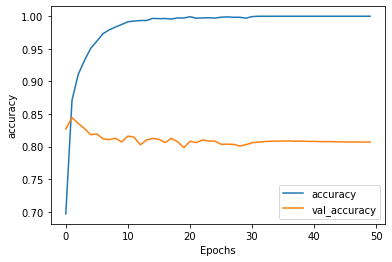

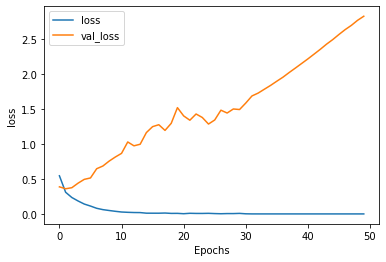

In [6]:
import matplotlib.pyplot as plt


def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

plot_graphs(history, 'accuracy')
plot_graphs(history, 'loss')